In [17]:
# Import necessary libaries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from requests import get

In [18]:
from fake_useragent import UserAgent

ua1 = UserAgent()
randomHeader = {'User-Agent':str(ua1.random)}

In [19]:
# Make a request
url = 'https://covid19.ncdc.gov.ng'
response = get(url, randomHeader, headers = {"Accept-Language": "en-US, en;q=0.5"})

In [20]:
print(response.text[:500])

<!DOCTYPE html>
<html lang="en">
<meta http-equiv="content-type" content="text/html;charset=UTF-8" />
<head>
<title>NCDC Coronavirus COVID-19 Microsite</title>
<!--[if lt IE 11]>
    	<script src="https://oss.maxcdn.com/libs/html5shiv/3.7.0/html5shiv.js"></script>
    	<script src="https://oss.maxcdn.com/libs/respond.js/1.4.2/respond.min.js"></script>
    	<![endif]-->
<meta charset="utf-8">
<meta name="viewport" content="width=device-width, initial-scale=1.0, user-scalable=0, minimal-ui">
<meta


In [21]:
# Create a beautifulsoup object
html_soup = BeautifulSoup(response.text, 'html.parser')
type(html_soup)

bs4.BeautifulSoup

In [22]:
# Locate table
covid_table = html_soup.find('div', class_ = 'table-responsive')

In [23]:
# Scrape table headers and pass into a list
table_heading = covid_table.thead.find_all('th')
headings = []
for th in table_heading:
    headings.append(th.text)
print(headings)

['States Affected', 'No. of Cases (Lab Confirmed)', 'No. of Cases (on admission)', 'No. Discharged', 'No. of Deaths']


In [24]:
# Scrape table rows and pass into a list
table_rows = []
for i in covid_table.tbody.find_all('tr'):
    table_rows.append(i.text.replace('\n', ' ').strip())
table_rows

['Lagos  12,711  10,601  1,935  175',
 'FCT  2,687  1,838  810  39',
 'Oyo  1,882  855  1,008  19',
 'Edo  1,807  708  1,039  60',
 'Rivers  1,397  405  946  46',
 'Delta  1,392  775  583  34',
 'Kano  1,314  227  1,035  52',
 'Ogun  1,105  338  745  22',
 'Kaduna  1,039   367  660  12',
 'Ondo  747  588  138  21',
 'Katsina  669  205  441  23',
 'Ebonyi  616  102  508  6',
 'Borno  593  94  464  35',
 'Plateau  571  295  260  16',
 'Gombe  533   86  425  22',
 'Bauchi  521  3  505  13',
 'Enugu  515  177  322  16',
 'Kwara  422  229  179  14',
 'Abia  413  115  295  3',
 'Imo  399  318  73  8',
 'Jigawa  321  2  308  11',
 'Bayelsa  318  147  153  18',
 'Osun  276  184  84  8',
 'Nasarawa  252  131  113  8',
 'Sokoto  153  1  136  16',
 'Akwa Ibom  145  59  83  3',
 'Niger  145  30  108  7',
 'Benue  126  85  35  6',
 'Adamawa  110  20  83  7',
 'Anambra  101  27  65  9',
 'Kebbi  87  6  74  7',
 'Zamfara  76  0  71  5',
 'Ekiti   66  24  40  2',
 'Yobe  62  3  51  8',
 'Taraba  30  1

In [25]:
# Format table rows for dataframe
table_rows = [i.split() for i in table_rows]
table_rows

[['Lagos', '12,711', '10,601', '1,935', '175'],
 ['FCT', '2,687', '1,838', '810', '39'],
 ['Oyo', '1,882', '855', '1,008', '19'],
 ['Edo', '1,807', '708', '1,039', '60'],
 ['Rivers', '1,397', '405', '946', '46'],
 ['Delta', '1,392', '775', '583', '34'],
 ['Kano', '1,314', '227', '1,035', '52'],
 ['Ogun', '1,105', '338', '745', '22'],
 ['Kaduna', '1,039', '367', '660', '12'],
 ['Ondo', '747', '588', '138', '21'],
 ['Katsina', '669', '205', '441', '23'],
 ['Ebonyi', '616', '102', '508', '6'],
 ['Borno', '593', '94', '464', '35'],
 ['Plateau', '571', '295', '260', '16'],
 ['Gombe', '533', '86', '425', '22'],
 ['Bauchi', '521', '3', '505', '13'],
 ['Enugu', '515', '177', '322', '16'],
 ['Kwara', '422', '229', '179', '14'],
 ['Abia', '413', '115', '295', '3'],
 ['Imo', '399', '318', '73', '8'],
 ['Jigawa', '321', '2', '308', '11'],
 ['Bayelsa', '318', '147', '153', '18'],
 ['Osun', '276', '184', '84', '8'],
 ['Nasarawa', '252', '131', '113', '8'],
 ['Sokoto', '153', '1', '136', '16'],
 ['Ak

In [26]:
# Locate index position of Akwa Ibom
def get_index(strings, substr):
    for idx, string in enumerate(strings):
        if substr in string:
            break
    return idx

In [27]:
idx = get_index(table_rows, 'Akwa')

In [28]:
# Join 'Akwa' and 'Ibom'
del table_rows[idx][1]
table_rows[idx][0] = 'Akwa Ibom'
table_rows

[['Lagos', '12,711', '10,601', '1,935', '175'],
 ['FCT', '2,687', '1,838', '810', '39'],
 ['Oyo', '1,882', '855', '1,008', '19'],
 ['Edo', '1,807', '708', '1,039', '60'],
 ['Rivers', '1,397', '405', '946', '46'],
 ['Delta', '1,392', '775', '583', '34'],
 ['Kano', '1,314', '227', '1,035', '52'],
 ['Ogun', '1,105', '338', '745', '22'],
 ['Kaduna', '1,039', '367', '660', '12'],
 ['Ondo', '747', '588', '138', '21'],
 ['Katsina', '669', '205', '441', '23'],
 ['Ebonyi', '616', '102', '508', '6'],
 ['Borno', '593', '94', '464', '35'],
 ['Plateau', '571', '295', '260', '16'],
 ['Gombe', '533', '86', '425', '22'],
 ['Bauchi', '521', '3', '505', '13'],
 ['Enugu', '515', '177', '322', '16'],
 ['Kwara', '422', '229', '179', '14'],
 ['Abia', '413', '115', '295', '3'],
 ['Imo', '399', '318', '73', '8'],
 ['Jigawa', '321', '2', '308', '11'],
 ['Bayelsa', '318', '147', '153', '18'],
 ['Osun', '276', '184', '84', '8'],
 ['Nasarawa', '252', '131', '113', '8'],
 ['Sokoto', '153', '1', '136', '16'],
 ['Ak

In [29]:
idx = get_index(table_rows, 'Cross')

In [30]:
# Join 'Cross' and 'River'
del table_rows[idx][1]
table_rows[idx][0] = 'Cross River'
table_rows

[['Lagos', '12,711', '10,601', '1,935', '175'],
 ['FCT', '2,687', '1,838', '810', '39'],
 ['Oyo', '1,882', '855', '1,008', '19'],
 ['Edo', '1,807', '708', '1,039', '60'],
 ['Rivers', '1,397', '405', '946', '46'],
 ['Delta', '1,392', '775', '583', '34'],
 ['Kano', '1,314', '227', '1,035', '52'],
 ['Ogun', '1,105', '338', '745', '22'],
 ['Kaduna', '1,039', '367', '660', '12'],
 ['Ondo', '747', '588', '138', '21'],
 ['Katsina', '669', '205', '441', '23'],
 ['Ebonyi', '616', '102', '508', '6'],
 ['Borno', '593', '94', '464', '35'],
 ['Plateau', '571', '295', '260', '16'],
 ['Gombe', '533', '86', '425', '22'],
 ['Bauchi', '521', '3', '505', '13'],
 ['Enugu', '515', '177', '322', '16'],
 ['Kwara', '422', '229', '179', '14'],
 ['Abia', '413', '115', '295', '3'],
 ['Imo', '399', '318', '73', '8'],
 ['Jigawa', '321', '2', '308', '11'],
 ['Bayelsa', '318', '147', '153', '18'],
 ['Osun', '276', '184', '84', '8'],
 ['Nasarawa', '252', '131', '113', '8'],
 ['Sokoto', '153', '1', '136', '16'],
 ['Ak

In [31]:
# Pass table rows into data frame
data = pd.DataFrame(table_rows)
data.head()

,0,1,2,3,4
0,Lagos,"12,711","10,601","1,935",175
1,FCT,"2,687","1,838",810,39
2,Oyo,"1,882",855,"1,008",19
3,Edo,"1,807",708,"1,039",60
4,Rivers,"1,397",405,946,46


In [32]:
# Set table headers from headings list
data.columns = headings
data.head()

,States Affected,No. of Cases (Lab Confirmed),No. of Cases (on admission),No. Discharged,No. of Deaths
0,Lagos,"12,711","10,601","1,935",175
1,FCT,"2,687","1,838",810,39
2,Oyo,"1,882",855,"1,008",19
3,Edo,"1,807",708,"1,039",60
4,Rivers,"1,397",405,946,46


In [33]:
# Remove all commas from columns
data.replace(',','', regex=True, inplace=True)

In [34]:
col = data.select_dtypes(object).columns[1:]
data[col] = data[col].apply(pd.to_numeric, errors='coerce')

In [35]:
data.dtypes

States Affected                 object
No. of Cases (Lab Confirmed)     int64
No. of Cases (on admission)      int64
No. Discharged                   int64
No. of Deaths                    int64
dtype: object

In [36]:
# Rename FCT to Abuja FCT
data.loc[data['States Affected'] == 'FCT', 'States Affected'] = 'Federal Capital Territory'

In [37]:
data.columns = ['States', 'Cases', 'Infected', 'Recoveries', 'Deaths']

In [38]:
data.head(3)

,States,Cases,Infected,Recoveries,Deaths
0,Lagos,12711,10601,1935,175
1,Federal Capital Territory,2687,1838,810,39
2,Oyo,1882,855,1008,19


In [39]:
# Export data frame to csv
data.to_csv('covid_nigeria.csv')

In [40]:
# Import libararies for map plotting
import geopandas as gpd
import geoplot as gpt
import matplotlib.pyplot as plt

In [41]:
# Load SHP files
shp = r'shapefile/Nigeria_Poly.shp'
shapefile = gpd.read_file(shp)

In [42]:
type(shapefile), shapefile.shape

(geopandas.geodataframe.GeoDataFrame, (37, 16))

In [43]:
shapefile.columns

Index(['id', 'country', 'name', 'enname', 'locname', 'offname', 'boundary',
       'adminlevel', 'wikidata', 'wikimedia', 'timestamp', 'note', 'path',
       'rpath', 'iso3166_2', 'geometry'],
      dtype='object')

In [44]:
# Drop unecassary columns
shapefile = shapefile.drop(['id', 'country', 'name', 'enname', 'offname', 'boundary',
       'adminlevel', 'wikidata', 'wikimedia', 'timestamp', 'note', 'path',
       'rpath', 'iso3166_2'], axis=1)

In [45]:
shapefile.columns = ['States', 'geometry']

In [46]:
shapefile.head(2)

,States,geometry
0,Abia,"POLYGON ((7.14043 4.90063, 7.14377 4.91320, 7...."
1,Adamawa,"POLYGON ((11.34152 8.01867, 11.34154 8.02210, ..."


In [47]:
# Merge GeoDataFrame with covid statistics data
data = shapefile.merge(data, left_on='States', right_on='States')

In [48]:
type(data), data.shape

(geopandas.geodataframe.GeoDataFrame, (37, 6))

In [49]:
data.head(2)

,States,geometry,Cases,Infected,Recoveries,Deaths
0,Abia,"POLYGON ((7.14043 4.90063, 7.14377 4.91320, 7....",413,115,295,3
1,Adamawa,"POLYGON ((11.34152 8.01867, 11.34154 8.02210, ...",110,20,83,7


In [50]:
# Define plot function
def visual(data, hue, cmap):
    fig, ax = plt.subplots(1, figsize=(38, 13))
    ax.set_title('Coronavirus {} by States'.format(hue), fontdict={'fontsize': '20', 'fontweight' : '3'})
    gpt.choropleth(data, hue=hue, cmap=cmap,
                   legend=True,edgecolor='lightgray', linewidth=0.1,
                   ax=ax,legend_kwargs={'aspect':30, 'label':'Counts', 'fraction':0.036, 'pad':0, 'orientation':'horizontal'});

    data['coords'] = data['geometry'].apply(lambda x: x.representative_point().coords[:])
    data['coords'] = [coords[0] for coords in data['coords']]

    for idx, row in data.iterrows():
        ax.annotate(s=row['States'], xy=row['coords'], color='black', fontsize=13, horizontalalignment='center')
        plt.savefig('{}.png'.format(hue.lower()), dpi=150)

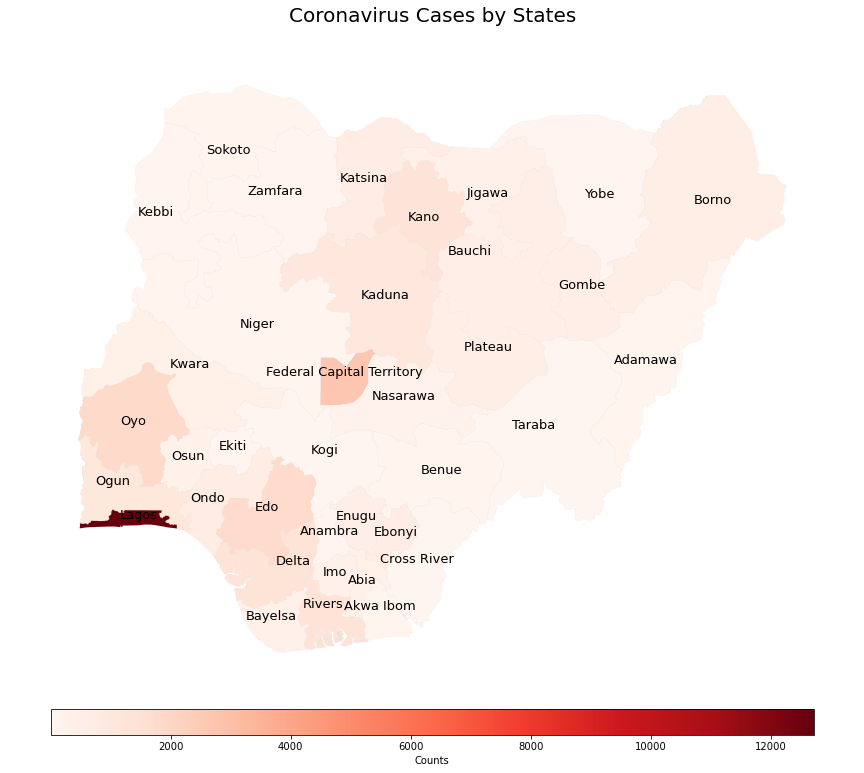

In [51]:
# Plot geomap for cases
visual(data, 'Cases', 'Reds')

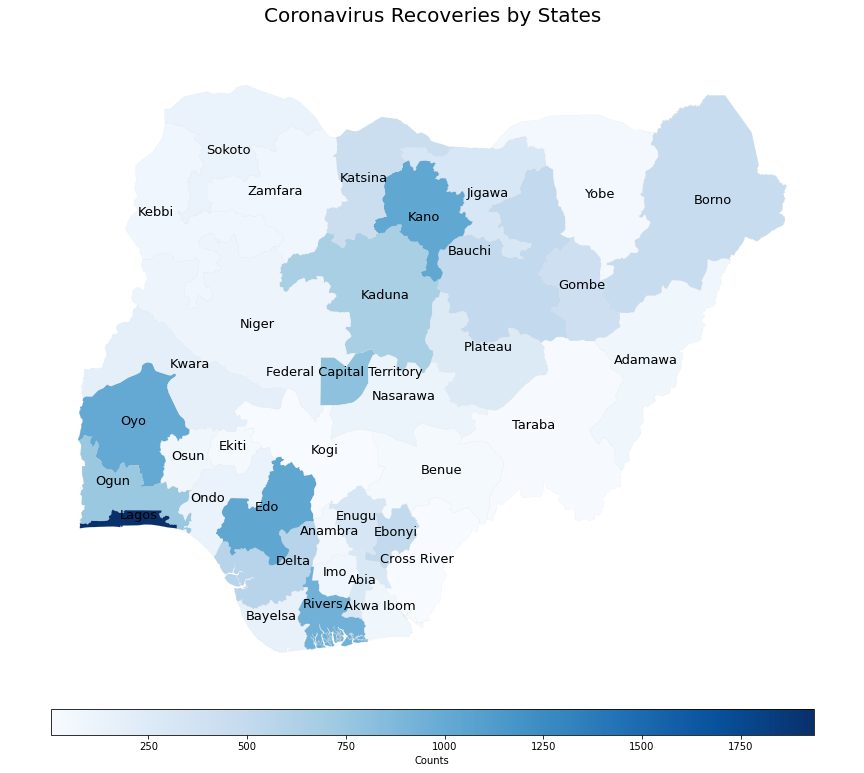

In [52]:
# Plot geomap for recoveries
visual(data, 'Recoveries', 'Blues')

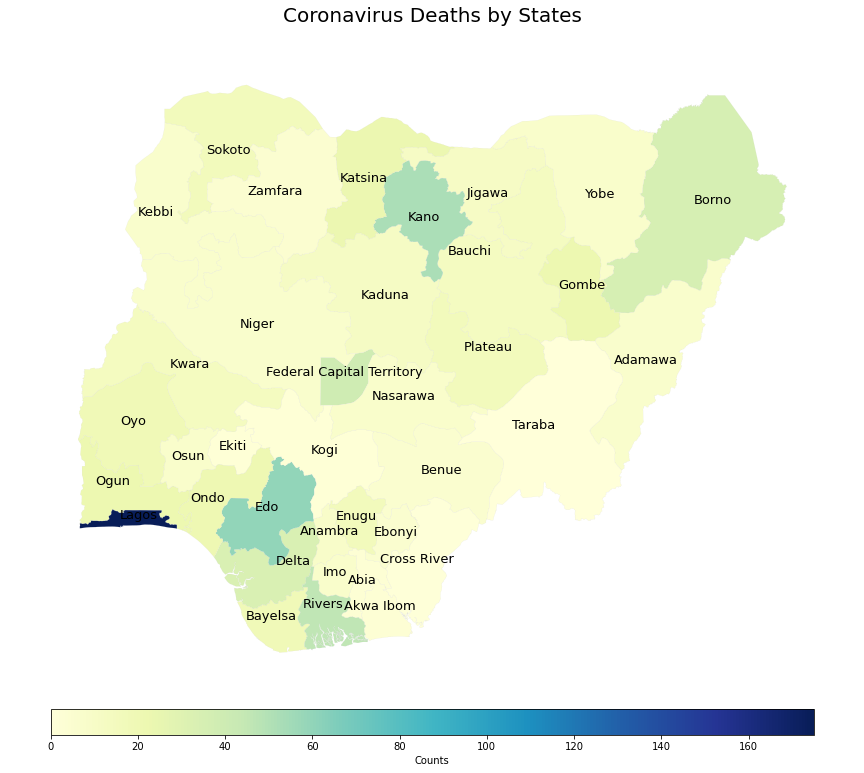

In [53]:
# Plot geomap for deaths
visual(data, 'Deaths', 'YlGnBu')

<h1 align='center'>Time Series Data</h1>

<p>Download data from Johns Hopkins University (JHU) Center for Systems Science and Engineering's (CSSE) GitHub repository</p>

In [54]:
cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

In [55]:
recovs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [56]:
deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

In [57]:
# Read data into data frame
df_cases = pd.read_csv(cases)
df_recovs = pd.read_csv(recovs)
df_deaths = pd.read_csv(deaths)

In [58]:
# Extract confirmed cases data for Nigeria
df_cases.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df_cases.set_index('Country/Region', inplace=True)
df_cases = df_cases.loc['Nigeria']
df_cases = pd.DataFrame(df_cases)
df_cases.columns = ['Cases']
df_cases = df_cases.loc['2/28/20':]

In [59]:
# Extract recoveries data for Nigeria
df_recovs.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df_recovs.set_index('Country/Region', inplace=True)
df_recovs = df_recovs.loc['Nigeria']
df_recovs = pd.DataFrame(df_recovs)
df_recovs.columns = ['Recoveries']
df_recovs = df_recovs.loc['2/28/20':]

In [60]:
# Extract death data for Nigeria
df_deaths.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df_deaths.set_index('Country/Region', inplace=True)
df_deaths = df_deaths.loc['Nigeria']
df_deaths = pd.DataFrame(df_deaths)
df_deaths.columns = ['Deaths']
df_deaths = df_deaths.loc['2/28/20':]

In [61]:
# Merge cases, recoveriies and death data into one data frame
time_series = pd.concat([df_cases, df_recovs, df_deaths], axis=1, ignore_index=False)

In [62]:
# Rename columns
time_series.reset_index(inplace=True)
time_series.columns = ['Time', 'Cases', 'Recoveries', 'Deaths']

In [63]:
# Set time column type to datetime

#date = pd.date_range("1 22 2020", periods=time_series.shape[0], freq="D", name="date")
time_series['Time'] = pd.to_datetime(time_series['Time'], errors='coerce')

In [64]:
# Make time column index of the data frame
time_series.set_index('Time', inplace=True)

In [65]:
time_series = time_series.asfreq('D', method = 'ffill')

In [66]:
time_series.head()

,Cases,Recoveries,Deaths
Time,,,
2020-02-28,1,0,0
2020-02-29,1,0,0
2020-03-01,1,0,0
2020-03-02,1,0,0
2020-03-03,1,0,0


In [67]:
# Export time series data to csv
time_series.to_csv('time_series.csv')

In [68]:
# Import libraries for plotting
import seaborn as sns
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

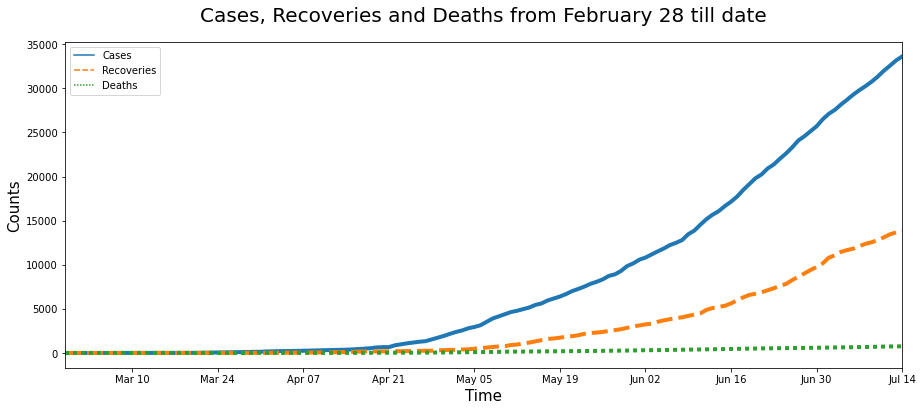

In [71]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=time_series, ax=ax, linewidth=4)
ax.set_title('Cases, Recoveries and Deaths from February 28 till date', fontdict={'fontsize': '20', 'fontweight' : '3'}, pad=20)
ax.set_ylabel('Counts', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlabel('Time', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlim(time_series.index[0], time_series.index[-1])

# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
# Format x-tick labels to show at 2 weeks interval
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
# Save figure
plt.savefig('line-plot.png', dpi=150)

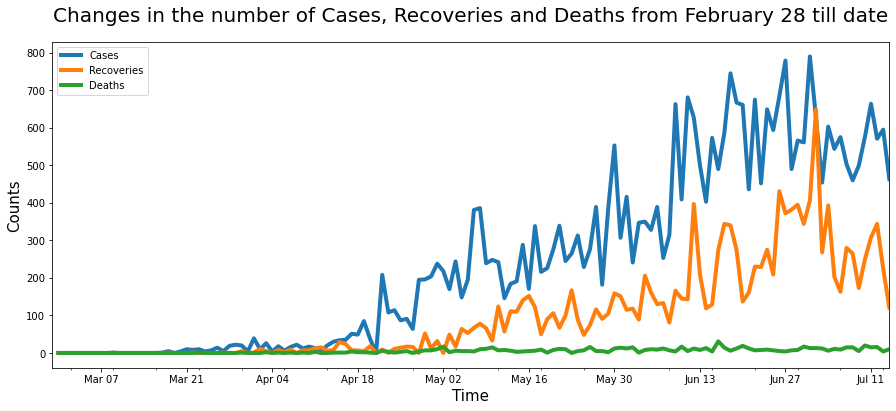

In [70]:
fig, ax = plt.subplots(figsize=(15, 6))
time_series.diff().plot(ax=ax, linewidth=4)
ax.set_title('Changes in the number of Cases, Recoveries and Deaths from February 28 till date', fontdict={'fontsize': '20', 'fontweight' : '3'}, pad=20)
ax.set_ylabel('Counts', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlabel('Time', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.set_xlim(time_series.index[0], time_series.index[-1])

# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
# Format x-tick labels to show at 2 weeks interval
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
# Save figure
plt.savefig('time-lag.png', dpi=150)